In [86]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt

In [36]:
def assign_to_grid(xcord, ycord, xgridsize, ygridsize, xmin, xrange, ymin, yrange):
    # Assign a lat and long coordinate to a grid location. Input xcord, ycord as lat/long to be mapped
    # gridsize is dimension of matrix
    # min is smallest lat/long coordinate, range is max(xcoordinate) - min(xcoordinate) and repeat for y
    
    xbin = int((xcord-xmin)/(xmax-xmin)*xgridsize)+1
    ybin = int((ycord-ymin)/(ymax-ymin)*ygridsize)+1
    return xbin, ybin

#xmax =  data['XCOORD'].max()
#xmin =  data['XCOORD'].min()
#xrange = xmax-xmin
#ymax =  data['YCOORD'].max()
#ymin =  data['YCOORD'].min()
#yrange = ymax-ymin

#xgridsize = 50
#ygridsize = int(xgridsize*yrange/xrange)

#points = []
#for i in range(0, 400):
#    point = assign_to_grid(data['XCOORD'][i], data['YCOORD'][i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
#    points.append(point)
#plt.plot(*zip(*points), marker='o', color='b', ls='')
#plt.title("Gridded Event Locations")

In [35]:
def global_update(F_xy, w, time_delta_last_time, theta, mu_xy):
# Decay triggering exponentials and calculate current intensities for all grids
    for k in range(0, len(w)):
        F_xy[k] = F_xy[k] * np.exp(-1*w[k]*time_delta_last_time)
    Lam_xy = mu_xy+sum(F_xy)
    
    return F_xy, Lam_xy

In [261]:
def event_update(mu_g, Lam_g, time_delta_last_g_time, theta, w, F_g, time_delta_last_time):
# update mu, theta and triggering exponentials for grids where event occurred
    dt = time_delta_last_time # should this be constant or not??
    mu_g = mu_g + dt*(mu_g/Lam_g - mu_g*time_delta_last_g_time)
    for k in range(0, len(w)):
        theta[k] = theta[k] + dt * (F_g[k]/Lam_g-theta[k])
        F_g[k] = F_g[k] + w[k]*theta[k]
        
    return mu_g, theta, F_g

#### Testing on generated data

In [229]:
def ESTProcess(mu, k0, w, T):
    p = pois(mu*T)
    times = np.random.uniform(0, T, p) #(low, high, size)
    counts = 0
    countf = p-1

    while(countf>=counts):
        p=pois(k0)    #each event generates p offspring according to a Poisson r.v. with parameter k0
        for j in range(0, p-1):
            temp=times[counts]-np.log(np.random.rand())/w    #this generates an exponential r.v. on [t_counts,infty]
            if(temp < T):    
                times = np.append(times, temp)
                countf=countf+1
        counts=counts+1

    times = times[0:countf]
    
    return times

    
def pois(S):
    if S <= 100:
        temp = -1*S
        L = exp(temp)
        k = 0
        p = 1
        while p > L:
            k = k + 1
            p = p * random()
        p = k - 1
    else:
        p = floor(S + sqrt(S) * random())
    return int(p)


In [230]:
mu = .4
k0 = .1
w_exact = .3
T = 5000000
test_times = ESTProcess(mu, k0, w_exact, T)
test_times = np.sort(test_times)

In [ ]:
# initial parameters
w = [.5, .1, .05]
theta = [.2, .02, .02]

events = len(test_times)

mu = .9
F = np.ones(len(w))
Lam = np.ones(events)*0.01

# (tracking model parameters)
t1 = []
t2 = []
t3 = []
mu_track = []
F_track = []

for i in range(1, events):
    
    time_delta = (test_times[i]- test_times[i-1])/10000
    
    # update exponentials, intensities (for all grid boxes)
    F, Lam[i] = global_update(F, w, time_delta, theta, mu) 
            
    # update model parameters based on grid box where current event happened, mu and theta are global. F is for 
    # box where event occurred (though in this case there is only one box)
    mu, theta, F = event_update(mu, Lam[i], time_delta, theta, w, F, time_delta)
    
    # (tracking model parameters)
    t1.append(theta[0])
    t2.append(theta[1])
    t3.append(theta[2])
    mu_track.append(mu)
    F_track.append(F)  

In [ ]:
t= np.arange(0,100, .5)
F = theta[0]*w[0]*np.exp(-w[0]*t) + theta[1]*w[1]*np.exp(-w[1]*t) + theta[2]*w[2]*np.exp(-w[2]*t)
F0=k0 * w_exact * np.exp(-w_exact*t)
plt.plot(F, 'b')
plt.plot(F0, 'r')
plt.show()

In [ ]:
plt.plot(mu_track)

In [ ]:
t_est = np.zeros(events-1)
for i in range(0, events-1):
    t_est[i] = t1[i] + t2[i] + t3[i]

plt.plot(t_est, 'b.')
#plt.plot(t1, 'r.')
#plt.plot(t2, 'g.')
#plt.plot(t3, 'm.')
plt.show()

#### Actual data

In [385]:
data = pd.read_csv('FixedLatLongTimeLoc.csv')
data['DATE_TIME'] =  pd.to_datetime(data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
data.head()

/home/march/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,CALL_NO,UNIT_DISPATCH_DATE,DISPATCH_TIME,CALL_TYPE_FINAL,CALL_TYPE_FINAL_D,XCOORD,YCOORD,DATE_TIME
0,0,61209515,2006-12-28,44548,773A,UNCONSCIOUS PERS,39.824332,-86.236119,2006-12-28 04:45:48
1,1,61209516,2006-12-28,44853,774A,ASSAULT/TRAUMA,39.781627,-86.120826,2006-12-28 04:48:53
2,2,61209517,2006-12-28,45219,768A,SEIZURE,39.756840,-85.998714,2006-12-28 04:52:19
3,3,61209519,2006-12-28,51057,773A,UNCONSCIOUS PERS,39.782064,-86.044592,2006-12-28 05:10:57
4,4,61209520,2006-12-28,51756,790A,*MEDICAL ALARM,39.742415,-86.111559,2006-12-28 05:17:56


In [ ]:
# set up grid sizing
xmax =  data['XCOORD'].max()
xmin =  data['XCOORD'].min()
xrange = xmax-xmin
ymax =  data['YCOORD'].max()
ymin =  data['YCOORD'].min()
yrange = ymax-ymin

xgridsize = 50
ygridsize = int(xgridsize*yrange/xrange)

# initial parameters
w = [.5, .1, .05]
theta = [.5, .5, .5]

mu = np.ones([xgridsize, ygridsize])*.1
F = np.ones([xgridsize, ygridsize, len(w)])
Lam = np.ones([events, xgridsize, ygridsize])*0.0001

# number of datapoints to take from ems dataset
events = 400

# for storing time of past event in specific grid cell
G_times = pd.DataFrame(np.zeros([xgridsize, ygridsize]))

# (tracking model parameters)
t1 = []
t2 = []
t3 = []
mu_track = []
F_track = []

for i in range(1, events):
    # assign event to a grid
    gx, gy = assign_to_grid(data.XCOORD[i], data.YCOORD[i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
    # time since last event in any grid box 
    time_delta = (data.DATE_TIME[i]- data.DATE_TIME[i-1]).total_seconds()/1000
    
    # update exponentials, intensities for all grid boxes
    for x in range(xgridsize):
        for y in range(ygridsize):
            F[x][y], Lam[i][x][y] = global_update(F[x][y], w, time_delta, theta, mu[x][y]) 
            
    # find last time event occurred at this grid location
    last_g_time = pd.to_datetime(G_times.at[gx,gy])
    # find delta between last event time and current time. 
    g_time_delta = (data.DATE_TIME[i] - last_g_time).total_seconds()/1000
    # update event time for this location
    G_times.at[gx,gy] = data.DATE_TIME[i]
    
    # update model parameters based on grid box where current event happened
    mu[gx][gy], theta, F[gx][gy] = event_update(mu[gx][gy], Lam[i][gx][gy], g_time_delta, theta, w, F[gx][gy], time_delta)
    
    # (tracking model parameters)
    t1.append(theta[0])
    t2.append(theta[1])
    t3.append(theta[2])
    mu_track.append(mu)
    F_track.append(F)
    
    #print(i/events*100)    

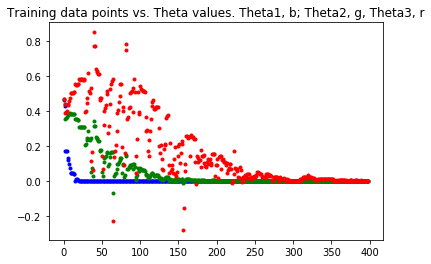

In [447]:
plt.plot(t1, 'b.')
plt.plot(t2, 'g.')
plt.plot(t3, 'r.')
plt.title('Training data points vs. Theta values. Theta1, b; Theta2, g, Theta3, r')
plt.show()

KeyboardInterrupt: 

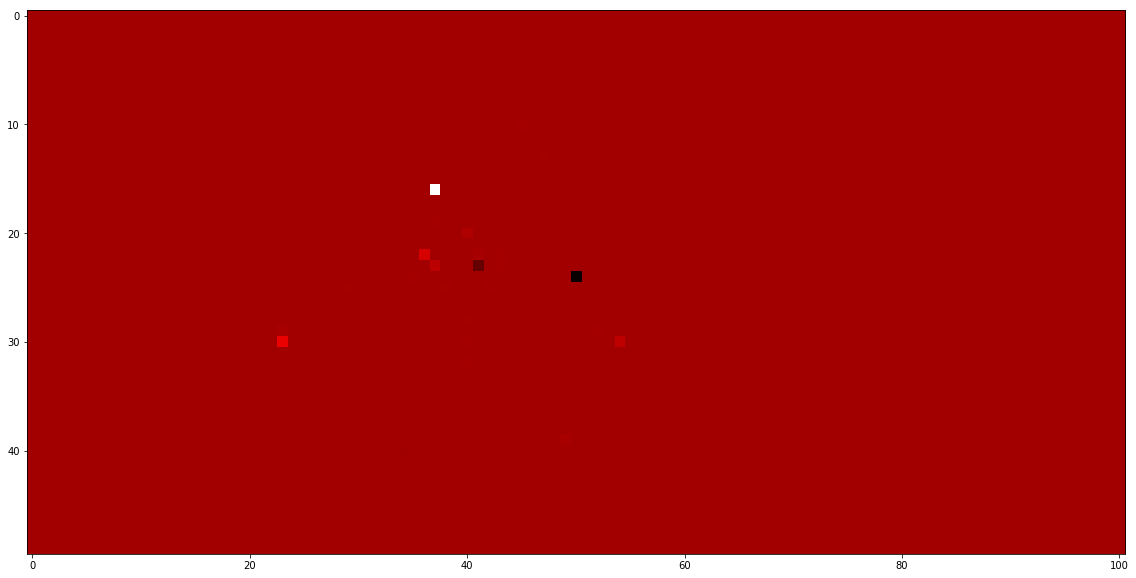

In [467]:
import time
import pylab as pl
from IPython import display
plt.figure(figsize=(20,10))
for n in range(0, int(events/10)):
    i = n*10    
    plt.imshow((Lam[i]), cmap = 'hot', interpolation = 'nearest')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.0005)

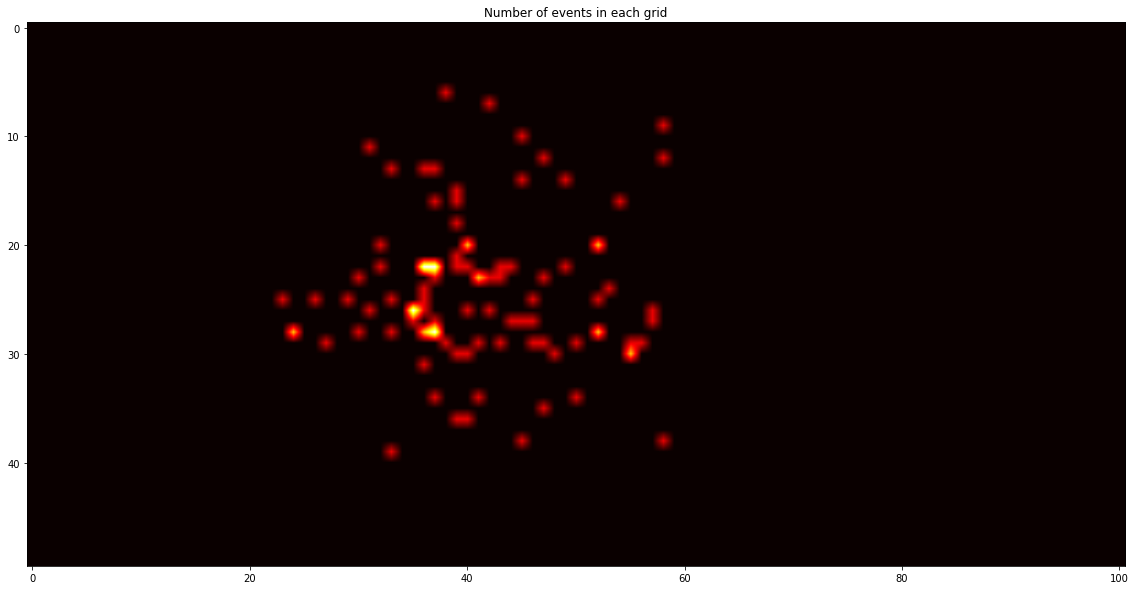

In [456]:
data_intensity = np.zeros([xgridsize, ygridsize])
for i in range(events-100, events):
    x, y = assign_to_grid(data['XCOORD'][i], data['YCOORD'][i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
    data_intensity[x][y] = data_intensity[x][y] + 1

plt.figure(figsize=(20,10))
plt.imshow(data_intensity, cmap = 'hot', interpolation = 'bilinear')
plt.title("Number of events in each grid")
plt.show()

In [ ]:
points = []
for i in range(0, events):
    point = assign_to_grid(data['XCOORD'][i], data['YCOORD'][i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
    points.append(point)
points.append(assign_to_grid(data['XCOORD'].max(), data['YCOORD'].max(), xgridsize, ygridsize, xmin, xrange, ymin, yrange))
plt.plot(*zip(*points), marker='o', color='b', ls='')
plt.title("Gridded Event Locations")